In [9]:
import os
import numpy as np
from os.path import abspath, exists
from scipy import sparse
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import csv
from collections import Counter

In [10]:
def import_graph():
    # read the graph from 'play_graph.txt'
    f_path = abspath("data/edges.txt")
    if exists(f_path):
        with open(f_path) as graph_file:
            lines = [line.split() for line in graph_file]
    ret = np.array(lines).astype(int)
#     print(len(ret))
#     print(ret.shape)
    return ret

In [11]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [12]:
def get_nodes_removing_unpaired(a):
    f_path = abspath("data/nodes.txt")
#     print(type(a[:,0][0]))
    ctr=0
    ret=[]
    if exists(f_path):
        with open(f_path) as nodes_file:
            for line in nodes_file.readlines():
                node = line.split("\t")[0]
                if int(node) in a[:,0] or int(node) in a[:,1]:
                    ctr+=1
                    ret.append([int(node),line.split("\t")[0],line.split("\t")[2]])
                
#     print(ctr)
    return ret
                

            

In [13]:
def get_unique_nodes_in_edges(a):
    i=a[:,0]
    j=a[:,1]
    ik=np.append(i, j, 0)
    dedupedi=list(dict.fromkeys(ik))
    dedupedi.sort()
    return dedupedi

In [14]:
#@Param k_clusters: number of different values of k that the code has to be run.
#@Param verbose: prints a lot of data if set to True. Using this to avoid a lot   
#               of clutter in the output when the number of k values to be tested is large
# Reference: Used the demo code provided by professor to read the graph and determine eigen values
def runSpectralClustering(k_clusters=(2,5,10,20), verbose=True):
    
    
    
    # load the graph
    a = import_graph()
    
    # get all the unique nodes from edges
    dedupedi = get_unique_nodes_in_edges(a)
    
    # create an array to map nodes in edges list to seq number from 0.
    # this is done because after removing isolated nodes, we will be left with 1224 nodes 
    # instead of original 1490 nodes. But in nodes.txt, there are nodes exceeding 1224, so we 
    # have to re map the nodes to new numbering. Once the clusters are determined, we will refer back 
    # to this map to get the original node id.
    adjacency_node_mapping=np.array([[i, dedupedi[i]] for i in range(len(dedupedi))])
    
    
    if verbose:
        print("checking if the resulting node mapping is right, new index for node id 1488 is ",np.where(adjacency_node_mapping[:,1]==1488))
        print("checking for reverse mapping, node id for 1221 is ",adjacency_node_mapping[1221][1])
    
    # initializing empty adjaceny matrix
    A = np.zeros(shape=(1224,1224))
    
    # Looping through all the edges, 
    # getting the nodes of an edge, 
    # get the new index for that node id, 
    # set value equal to 1 for the co ordinates represented by te nodes in the edge.
    for edge in a:
        A[np.where(adjacency_node_mapping[:,1]==edge[0])[0],np.where(adjacency_node_mapping[:,1]==edge[1])[0]]=1
        A[np.where(adjacency_node_mapping[:,1]==edge[1])[0],np.where(adjacency_node_mapping[:,1]==edge[0])[0]]=1
    
    #check if the adjacency matrix is symmetric
    if not check_symmetric(A):
        raise error

    if verbose:
        display(A) 
    
    #caluclating the diagonal matrix
    D = np.diag(np.sum(A, axis=1))
    
    #calculate graph laplacian
    L = D - A
    
    

    mismatchList=[]
    klist=[]
    
     # calculating eigen values and eigen vector
    eigenValues, eigenVector = np.linalg.eig(L)
    
        
    for k in k_clusters:
        v=eigenValues.real
        x=eigenVector.real

        #sort the eigen values and pick the lowest k eigen values.
        # Reference: https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
        idx = v.argsort()[::1]   
        v = v[idx]
        x = x[:,idx]
        x = x[:, 0:k]

        # k-means
        kmeans = KMeans(n_clusters=k,init='random').fit(x)
        c_idx = kmeans.labels_

        # removing the nodes that are unpaired
        nodes_paired=np.array(get_nodes_removing_unpaired(a)).astype(int)

        # Determining the nodes that are clustered for each label.
        clusters=[]
        for i in range(k):
            ctr=0
            cluster=[]
            idx = [index for index, t in enumerate(c_idx) if t == i]
            for index in idx:
                ctr+=1
                corresponding_node=adjacency_node_mapping[index][1]
                row_idx_nodes=np.where(nodes_paired[:,0]==corresponding_node)[0]
                corresponding_node_name=nodes_paired[row_idx_nodes][0][1]
                corresponding_node_true_flag=nodes_paired[row_idx_nodes][0][2]
                item=(corresponding_node_name,corresponding_node_true_flag)
                cluster.append(item)
            clusters.append(cluster)


        i=1
        totalMismatches=0
        
        # Determining mismatches in each cluster and eventual mismatch for k
        for cluster in clusters:
            counter = Counter(elem[1] for elem in cluster)
            if verbose:
                print("entries in ",i,"th cluster: ",counter)
            count1= counter.get(1) if 1 in counter.keys() else 0
            count0= counter.get(0) if 0 in counter.keys() else 0
            if(count1>count0):
                clusterLabel=1
                totalMismatches=totalMismatches+count0
                if count1+count0>0:
                    mismatchRateCluster=count0/(count1+count0)
                else:
                    mismatchRateCluster = 0
            else:
                clusterLabel=0
                totalMismatches=totalMismatches+count1
                if count1+count0>0:
                    mismatchRateCluster=count1/(count1+count0)
                else:
                    mismatchRateCluster = 0
            if verbose:
                print("cluster label:", clusterLabel)
                print("count of 1:", count1)
                print("count of 0:", count0)
                print("mismatch rate:",mismatchRateCluster)
            i+=1
        totalMismatchRate=totalMismatches/1224
        klist.append(k)
        mismatchList.append(totalMismatchRate)
        if verbose or totalMismatchRate<0.05:
            print("total mismatch rate for k=",k, " is :",totalMismatchRate)
            print("***************************************************")
            print()
            print()
    if verbose is False:
        plt.plot(klist, mismatchList, marker='x')
        plt.title('k vs mismatch rate')
        plt.xlabel('k')
        plt.ylabel('mismatch rate')
        plt.show()
        minimumMismatch= min(mismatchList)
        k_min_mismatch=mismatchList.index(min(mismatchList))
        print("lowest mistmatch rate is :", minimumMismatch, " for k = ", k_min_mismatch+2)

In [15]:
#Q1.2 and Q1.3: Calling the runSpectralClustering method with default parameters.
#This will run the logic for K=2,5,10,20 and Verbose=True(full logging.)
runSpectralClustering()

checking if the resulting node mapping is right, new index for node id 1488 is  (array([1221]),)
checking for reverse mapping, node id for 1221 is  1488


array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

entries in  1 th cluster:  Counter({0: 2})
cluster label: 0
count of 1: 0
count of 0: 2
mismatch rate: 0.0
entries in  2 th cluster:  Counter({1: 636, 0: 586})
cluster label: 1
count of 1: 636
count of 0: 586
mismatch rate: 0.4795417348608838
total mismatch rate for k= 2  is : 0.47875816993464054
***************************************************


entries in  1 th cluster:  Counter({0: 2, 1: 2})
cluster label: 0
count of 1: 2
count of 0: 2
mismatch rate: 0.5
entries in  2 th cluster:  Counter({0: 2})
cluster label: 0
count of 1: 0
count of 0: 2
mismatch rate: 0.0
entries in  3 th cluster:  Counter({0: 2})
cluster label: 0
count of 1: 0
count of 0: 2
mismatch rate: 0.0
entries in  4 th cluster:  Counter({1: 630, 0: 582})
cluster label: 1
count of 1: 630
count of 0: 582
mismatch rate: 0.4801980198019802
entries in  5 th cluster:  Counter({1: 4})
cluster label: 1
count of 1: 4
count of 0: 0
mismatch rate: 0.0
total mismatch rate for k= 5  is : 0.477124183006536
*************************

total mismatch rate for k= 18  is : 0.04084967320261438
***************************************************


total mismatch rate for k= 19  is : 0.04820261437908497
***************************************************


total mismatch rate for k= 21  is : 0.04738562091503268
***************************************************


total mismatch rate for k= 24  is : 0.04656862745098039
***************************************************


total mismatch rate for k= 25  is : 0.042483660130718956
***************************************************


total mismatch rate for k= 26  is : 0.04656862745098039
***************************************************


total mismatch rate for k= 27  is : 0.041666666666666664
***************************************************


total mismatch rate for k= 28  is : 0.04820261437908497
***************************************************


total mismatch rate for k= 29  is : 0.041666666666666664
***************************************************


total m

total mismatch rate for k= 126  is : 0.0392156862745098
***************************************************


total mismatch rate for k= 127  is : 0.049019607843137254
***************************************************


total mismatch rate for k= 131  is : 0.042483660130718956
***************************************************


total mismatch rate for k= 132  is : 0.041666666666666664
***************************************************


total mismatch rate for k= 133  is : 0.041666666666666664
***************************************************


total mismatch rate for k= 134  is : 0.041666666666666664
***************************************************


total mismatch rate for k= 135  is : 0.04656862745098039
***************************************************


total mismatch rate for k= 137  is : 0.04084967320261438
***************************************************


total mismatch rate for k= 140  is : 0.041666666666666664
**************************************************

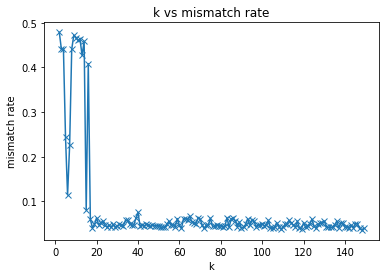

lowest mistmatch rate is : 0.03594771241830065  for k =  148


In [16]:
#Q1.4: Calling the runSpectralClustering method with K= 2 to 150 and Verbose=False.
k = range(2,150)
runSpectralClustering(k,verbose=False)